Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Source Kaggle Dataset: [US Accidents 2016-2023](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents)

In [2]:
accidents_df = pd.read_csv("D:/Programing/Weather2Go2/US_Accidents_March23.csv/US_Accidents_March23.csv")
accidents_df.shape


(7728394, 46)

In [3]:
accidents_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


Source Weather API: [Open Meteo](https://open-meteo.com/en/docs/historical-forecast-api?bounding_box=41.7,-90.5,48.3,-82.4&start_date=2016-01-01&end_date=2023-03-31&hourly=temperature_2m,weather_code,relative_humidity_2m,surface_pressure,visibility,wind_speed_10m,precipitation&temperature_unit=fahrenheit&wind_speed_unit=mph&precipitation_unit=inch&location_mode=csv_coordinates&csv_coordinates=42.3314,-83.0458%0A42.2808,-83.7430%0A42.7325,-84.5555%0A42.9634,-85.6681%0A43.0125,-83.6875%0A42.2917,-85.5872%0A44.7631,-85.6206%0A46.5436,-87.3954%0A46.4953,-84.3453%0A)

In [4]:
weather_df = pd.read_csv("D:/Programing/Weather2Go2/Data/mi_all_hourly_2016_2023.csv")
weather_df.shape

(1757232, 10)

In [5]:
weather_df.head()

,time,temperature_2m,weather_code,relative_humidity_2m,surface_pressure,visibility,wind_speed_10m,precipitation,latitude,longitude
0,2016-01-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311
1,2016-01-01 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311
2,2016-01-01 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311
3,2016-01-01 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311
4,2016-01-01 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311


In [6]:
weather_df = weather_df.dropna()
weather_df.shape

(1231032, 10)

Change Kaggle Weather Conditions to more minimal categories. 
"clear"
"cloudy"
"fog"
"rain_light"
"rain_heavy"
"snow_light"
"snow_heavy"
"freezing_rain"
"sleet_mix"
"thunder"
"hail"
"smoke_dust"
"severe"
"other"
"unknown"

In [7]:
CATS = [
  "clear","cloudy","fog","rain_light","rain_heavy","snow_light","snow_heavy",
  "freezing_rain","sleet_mix","thunder","hail","smoke_dust","severe","other","unknown"
]

def kaggle_weather_to_cat(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return "unknown"

    s = str(x).strip().lower()

    # remove common noise tokens but keep meaning
    # (we ignore "windy" as its own category; wind is handled by wind_speed feature)
    s = s.replace("/ windy", "").replace("windy", "").strip()

    # --- highest priority: truly severe phenomena ---
    if "tornado" in s or "funnel cloud" in s:
        return "severe"
    if "squall" in s:
        return "severe"
    if "duststorm" in s:
        return "severe"

    # --- hail (including small/light/heavy) ---
    if "hail" in s:
        return "hail"

    # --- thunder / t-storm ---
    if ("thunder" in s) or ("t-storm" in s) or ("tstorm" in s) or ("thunderstorm" in s):
        return "thunder"

    # --- freezing precip (most dangerous) ---
    # freezing drizzle/rain/fog -> treat as freezing risk bucket
    if "freezing" in s:
        return "freezing_rain"

    # --- sleet / ice pellets / wintry mix ---
    if ("sleet" in s) or ("ice pellet" in s) or ("wintry mix" in s) or ("rain and sleet" in s):
        return "sleet_mix"

    # --- snow (heavy vs light) ---
    if "snow" in s or "blowing snow" in s or "drifting snow" in s or "snow grains" in s:
        if "heavy" in s:
            return "snow_heavy"
        return "snow_light"

    # --- rain/drizzle/showers (heavy vs light) ---
    if ("rain" in s) or ("drizzle" in s) or ("shower" in s):
        if "heavy" in s:
            return "rain_heavy"
        return "rain_light"

    # --- fog/mist/haze ---
    if ("fog" in s) or ("mist" in s) or ("haze" in s):
        return "fog"

    # --- smoke/dust/sand/ash ---
    if ("smoke" in s) or ("dust" in s) or ("sand" in s) or ("ash" in s) or ("volcanic" in s):
        return "smoke_dust"

    # --- clouds ---
    if ("overcast" in s) or ("cloudy" in s) or ("scattered clouds" in s) or ("partly cloudy" in s) or ("mostly cloudy" in s):
        return "cloudy"

    # --- clear/fair ---
    if ("clear" in s) or (s == "fair") or s.startswith("fair "):
        return "clear"

    # --- explicit "n/a precipitation" should not force rain ---
    if "n/a precipitation" in s:
        return "other"

    return "other"


Change [NOAA Weather Code](https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM) to match simpler weather conditions.

In [8]:
def wmo_to_category(code: int) -> str:
    if code in [0]:
        return "clear"

    if code in [1, 2, 3]:
        return "cloudy"

    if code in [45, 48]:
        return "fog"

    # drizzle
    if code in [51, 53, 55]:
        return "rain_light"
    if code in [56, 57]:
        return "freezing_rain"

    # rain
    if code in [61, 63]:
        return "rain_light"
    if code in [65]:
        return "rain_heavy"
    if code in [66, 67]:
        return "freezing_rain"

    # snow
    if code in [71, 73, 77]:
        return "snow_light"
    if code in [75]:
        return "snow_heavy"

    # showers
    if code in [80, 81]:
        return "rain_light"
    if code in [82]:
        return "rain_heavy"
    if code in [85]:
        return "snow_light"
    if code in [86]:
        return "snow_heavy"

    # thunderstorms
    if code in [95]:
        return "thunder"
    if code in [96, 99]:
        return "hail"

    return "other"


Apply recode functions to both dataframes to new column, drop old columns.

In [9]:
# map WMO codes -> categories on the standardized weather dataframe
weather_df['Weather_Category'] = weather_df['weather_code'].apply(wmo_to_category)
weather_df = weather_df.drop(columns=['weather_code'])

# map free-text conditions -> categories on the standardized accidents dataframe
accidents_df['Weather_Category'] = accidents_df['Weather_Condition'].apply(kaggle_weather_to_cat)
accidents_df = accidents_df.drop(columns=['Weather_Condition'])

Changed both dataframes to have the same type for weather.

In [10]:
# standardize timestamp columns to timezone-aware UTC datetimes
accidents_col = 'Weather_Timestamp'
weather_time_col = 'time' if 'time' in weather_df.columns else 'Weather_Timestamp'

accidents_df[accidents_col] = pd.to_datetime(accidents_df[accidents_col], errors='coerce', utc=True)
weather_df['Weather_Timestamp'] = pd.to_datetime(weather_df[weather_time_col], errors='coerce', utc=True)

# remove original 'time' column if present to avoid confusion
if weather_time_col == 'time':
    weather_df.drop(columns=['time'], inplace=True)

# quick verification
print(accidents_df['Weather_Timestamp'].dtype, weather_df['Weather_Timestamp'].dtype)
print(accidents_df['Weather_Timestamp'].head())
print(weather_df['Weather_Timestamp'].head())

datetime64[ns, UTC] datetime64[ns, UTC]
0   2016-02-08 05:58:00+00:00
1   2016-02-08 05:51:00+00:00
2   2016-02-08 06:56:00+00:00
3   2016-02-08 07:38:00+00:00
4   2016-02-08 07:53:00+00:00
Name: Weather_Timestamp, dtype: datetime64[ns, UTC]
151940   2018-01-01 01:00:00+00:00
151941   2018-01-01 02:00:00+00:00
151942   2018-01-01 03:00:00+00:00
151943   2018-01-01 04:00:00+00:00
152684   2018-01-01 01:00:00+00:00
Name: Weather_Timestamp, dtype: datetime64[ns, UTC]


Subset to only Michigan accidents.

In [11]:
accidents_mi = accidents_df[accidents_df['State'] == 'MI']

Subset only columns that matched weather dataframe.

In [12]:
accidents_subset = accidents_mi[['Weather_Timestamp','Weather_Category','Temperature(F)',
                                 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                                 'Wind_Speed(mph)','Precipitation(in)','Start_Lat', 'Start_Lng']].copy()

### Target
Create target of Risk based on if it was in accident df or weather df.

In [13]:
accidents_subset['Risk'] = 1
weather_df['Risk'] = 0

Rename columns to same names.

In [14]:
weather_rename = {
    "time": "Weather_Timestamp",
    "temperature_2m": "Temperature_F",
    "weather_code": "Weather_Code",
    "relative_humidity_2m": "Humidity_Pct",
    "surface_pressure": "Pressure_in",
    "visibility": "Visibility_mi",
    "wind_speed_10m": "Wind_Speed_mph",
    "precipitation": "Precipitation_in",
    "latitude": "Start_Lat",
    "longitude": "Start_Lng",
}

weather_std = weather_df.rename(columns=weather_rename)


In [15]:
accident_rename = {
    "Weather_Timestamp": "Weather_Timestamp",
    "Temperature(F)": "Temperature_F",
    "Weather_Condition": "Weather_Condition",
    "Humidity(%)": "Humidity_Pct",
    "Pressure(in)": "Pressure_in",
    "Visibility(mi)": "Visibility_mi",
    "Wind_Speed(mph)": "Wind_Speed_mph",
    "Precipitation(in)": "Precipitation_in",
    "Start_Lat": "Start_Lat",
    "Start_Lng": "Start_Lng",
}

accidents_std = accidents_subset.rename(columns=accident_rename)


In [16]:
weather_std.head()


,Temperature_F,Humidity_Pct,Pressure_in,Visibility_mi,Wind_Speed_mph,Precipitation_in,Start_Lat,Start_Lng,Weather_Category,Weather_Timestamp,Risk
151940,8.936600,59.0,1010.33563,60367.453,1.703648,0.0,42.3206,-83.0311,clear,2018-01-01 01:00:00+00:00,0
151941,7.316601,63.0,1010.25240,53149.605,2.110382,0.0,42.3206,-83.0311,clear,2018-01-01 02:00:00+00:00,0
151942,5.156601,67.0,1010.04285,45931.758,1.140651,0.0,42.3206,-83.0311,clear,2018-01-01 03:00:00+00:00,0
151943,2.636601,73.0,1009.91095,38713.910,1.414803,0.0,42.3206,-83.0311,clear,2018-01-01 04:00:00+00:00,0
152684,2.769800,58.0,999.05260,63320.210,3.607054,0.0,42.2923,-83.7368,cloudy,2018-01-01 01:00:00+00:00,0


Sample weather data and merged with accidents.

In [17]:
weather_sample = weather_std[weather_std.index.isin(weather_std.sample(frac=0.3, random_state=42).index)]

In [18]:
merged_df = pd.concat([accidents_std] + [weather_sample], ignore_index=True, sort=False)

In [19]:
cat_features = ["Day_of_Week","Weather_Category"]
num_features = [
    "Temperature_F",
    "Humidity_Pct",
    "Wind_Speed_mph",
    "Precipitation_in",
    "Month",
    "Hour",
]


Size

In [20]:
print(f'Original weather observations: {weather_std.shape[0]}')
print(f'Sampled weather observations: {weather_sample.shape[0]}')
print(f'Michigan accidents subset observations: {accidents_subset.shape[0]}')
print(f'Combined dataframe: {merged_df.shape[0]}')

Original weather observations: 1231032
Sampled weather observations: 369310
Michigan accidents subset observations: 162191
Combined dataframe: 531501


Create new columns for Day of the Week, Month, and Hour.

In [21]:
# parse timestamp, extract day/month/hour, drop original timestamp
merged_df['Weather_Timestamp_parsed'] = pd.to_datetime(merged_df['Weather_Timestamp'], errors='coerce')
merged_df['Day_of_Week'] = merged_df['Weather_Timestamp_parsed'].dt.day_name()
merged_df['Month'] = merged_df['Weather_Timestamp_parsed'].dt.month
merged_df['Hour'] = merged_df['Weather_Timestamp_parsed'].dt.hour

merged_df = merged_df.drop(columns=['Weather_Timestamp', 'Weather_Timestamp_parsed'])

In [22]:
merged_df.head()

,Weather_Category,Temperature_F,Humidity_Pct,Pressure_in,Visibility_mi,Wind_Speed_mph,Precipitation_in,Start_Lat,Start_Lng,Risk,Day_of_Week,Month,Hour
0,cloudy,43.0,60.0,29.56,10.0,15.0,NaN,42.963215,-85.666740,1,Wednesday,11.0,15.0
1,cloudy,43.0,60.0,29.56,10.0,15.0,NaN,42.955772,-85.659164,1,Wednesday,11.0,15.0
2,cloudy,48.0,80.0,29.52,10.0,4.6,NaN,43.060432,-83.783752,1,Wednesday,11.0,16.0
3,cloudy,48.0,80.0,29.52,10.0,4.6,NaN,42.942875,-83.648453,1,Wednesday,11.0,16.0
4,cloudy,55.0,69.0,29.51,10.0,10.4,NaN,42.368423,-83.058128,1,Wednesday,11.0,15.0


### Clean missing values

In [23]:
merged_df.groupby('Risk')[['Pressure_in', 'Visibility_mi']].describe()

Pressure_in                                                           \
           count        mean        std        min         25%        50%   
Risk                                                                        
0       369310.0  987.967457  10.338554  932.63025  982.276525  989.12497   
1       161832.0   29.567576   0.490831   27.65000   29.150000   29.51000   

                           Visibility_mi                                   \
           75%         max         count          mean           std  min   
Risk                                                                        
0     994.9044  1021.37415      369310.0  70937.341412  38510.043826  0.0   
1      30.0100    31.15000      161676.0      8.478363      2.875007  0.0   

                                               
           25%        50%       75%       max  
Risk                                           
0     46916.01  62992.125  87598.43  295275.6  
1         9.00     10.000     10.00      12.0

Pressure and Visibility seem to be in different units, I tried converting but it seemed to lead to data leakage, so end up dropping the columns.

In [24]:
merged_df = merged_df.drop(columns=['Pressure_in', 'Visibility_mi'])

Missing values.

In [25]:
merged_df.isna().sum()

Weather_Category        0
Temperature_F         454
Humidity_Pct          529
Wind_Speed_mph       6683
Precipitation_in    58383
Start_Lat               0
Start_Lng               0
Risk                    0
Day_of_Week           201
Month                 201
Hour                  201
dtype: int64

In [26]:
clean_df = merged_df.dropna()

In [ ]:
clean_df = clean_df.drop(columns=['Start_Lat', 'Start_Lng'])


### Summary Statistics 

In [28]:
for col in num_features:
    summary = clean_df.groupby('Risk')[col].describe().round(2)
    print(f"Summary for {col}:")
    display(summary.transpose())

# categorical distributions (proportion) for key categorical cols
for col in cat_features:
    print(f"\n{col} distribution by Risk (proportion):")
    display(clean_df.groupby('Risk')[col].value_counts(normalize=True).unstack(fill_value=0).round(3))

Summary for Temperature_F:


Risk,0,1
count,369310.00,102767.00
mean,46.35,48.06
std,20.03,20.99
min,-27.47,-19.00
25%,31.24,31.00
50%,44.42,46.00
75%,63.33,66.00
max,97.50,98.00


Summary for Humidity_Pct:


Risk,0,1
count,369310.00,102767.00
mean,73.33,72.23
std,16.23,18.16
min,7.00,1.00
25%,63.00,60.00
50%,76.00,76.00
75%,86.00,87.00
max,100.00,100.00


Summary for Wind_Speed_mph:


Risk,0,1
count,369310.00,102767.00
mean,7.45,9.28
std,4.76,5.33
min,0.00,0.00
25%,3.81,6.00
50%,6.52,9.00
75%,10.13,13.00
max,46.00,38.00


Summary for Precipitation_in:


Risk,0,1
count,369310.00,102767.00
mean,0.00,0.01
std,0.05,0.04
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,6.24,1.89


Summary for Month:


Risk,0,1
count,369310.00,102767.00
mean,6.30,6.44
std,3.45,3.69
min,1.00,1.00
25%,3.00,3.00
50%,6.00,6.00
75%,9.00,10.00
max,12.00,12.00


Summary for Hour:


Risk,0,1
count,369310.00,102767.00
mean,11.51,11.71
std,6.92,5.69
min,0.00,0.00
25%,5.00,7.00
50%,12.00,12.00
75%,18.00,16.00
max,23.00,23.00



Day_of_Week distribution by Risk (proportion):


Day_of_Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Risk,,,,,,,
0,0.142,0.144,0.143,0.142,0.143,0.143,0.143
1,0.177,0.154,0.094,0.079,0.168,0.159,0.167



Weather_Category distribution by Risk (proportion):


Weather_Category,clear,cloudy,fog,freezing_rain,hail,other,rain_heavy,rain_light,sleet_mix,snow_heavy,snow_light,thunder,unknown
Risk,,,,,,,,,,,,,
0,0.426,0.500,0.019,0.001,0.0,0.000,0.002,0.028,0.000,0.002,0.022,0.002,0.000
1,0.287,0.422,0.019,0.003,0.0,0.001,0.005,0.112,0.005,0.004,0.132,0.010,0.001


In [29]:
clean_df.head(10)

,Weather_Category,Temperature_F,Humidity_Pct,Wind_Speed_mph,Precipitation_in,Risk,Day_of_Week,Month,Hour
8,cloudy,50.0,83.0,13.8,0.00,1,Wednesday,11.0,17.0
10,cloudy,50.0,83.0,13.8,0.00,1,Wednesday,11.0,17.0
14,rain_light,48.9,90.0,9.2,0.00,1,Wednesday,11.0,18.0
22,cloudy,37.9,86.0,15.0,0.01,1,Wednesday,11.0,20.0
26,rain_light,36.0,89.0,16.1,0.01,1,Thursday,12.0,4.0
27,cloudy,35.1,89.0,15.0,0.00,1,Thursday,12.0,4.0
28,cloudy,35.1,92.0,13.8,0.00,1,Thursday,12.0,5.0
30,rain_light,39.0,86.0,9.2,0.02,1,Thursday,12.0,6.0
31,snow_light,33.1,92.0,10.4,0.03,1,Thursday,12.0,6.0
35,rain_light,33.1,92.0,6.9,0.01,1,Thursday,12.0,7.0


### Test Train Split

In [30]:
X = clean_df.drop(columns=['Risk'])
y = clean_df['Risk']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')  
print(f'\nFeature columns: \n{X.columns.tolist()}')

Features shape: (472077, 8)
Target shape: (472077,)

Feature columns: 
['Weather_Category', 'Temperature_F', 'Humidity_Pct', 'Wind_Speed_mph', 'Precipitation_in', 'Day_of_Week', 'Month', 'Hour']


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training features shape: {X_train.shape}')
print(f'Training target shape: {y_train.shape}')   
print(f'\nTraining set class distribution:\n{y_train.value_counts(normalize=True)}')

Training features shape: (377661, 8)
Training target shape: (377661,)

Training set class distribution:
Risk
0    0.78231
1    0.21769
Name: proportion, dtype: float64


### Preprocessing for Pipeline

In [31]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features),
    ]
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")),
])

### Random Forest
Hyperparameter Tuning: Grid search to find the best Random Forest settings using F1-weighted.

In [34]:
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [10, 20],
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 2],
    "rf__max_features": ["sqrt"],
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=4,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV... (this may take a few minutes)")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-Score: {grid_search.best_score_:.4f}")

Starting GridSearchCV... (this may take a few minutes)
Fitting 4 folds for each of 16 candidates, totalling 64 fits

Best parameters: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best cross-validation F1-Score: 0.9335


In [35]:
best_model = grid_search.best_estimator_

rf_pred = best_model.predict(X_test)
rf_pred_proba = best_model.predict_proba(X_test)

print("Optimized Random Forest Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, rf_pred))

Optimized Random Forest Performance on Test Set:
Accuracy: 0.9318547703779021
F1 Score: 0.93284808256779
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     73862
           1       0.82      0.89      0.85     20554

    accuracy                           0.93     94416
   macro avg       0.89      0.92      0.90     94416
weighted avg       0.93      0.93      0.93     94416



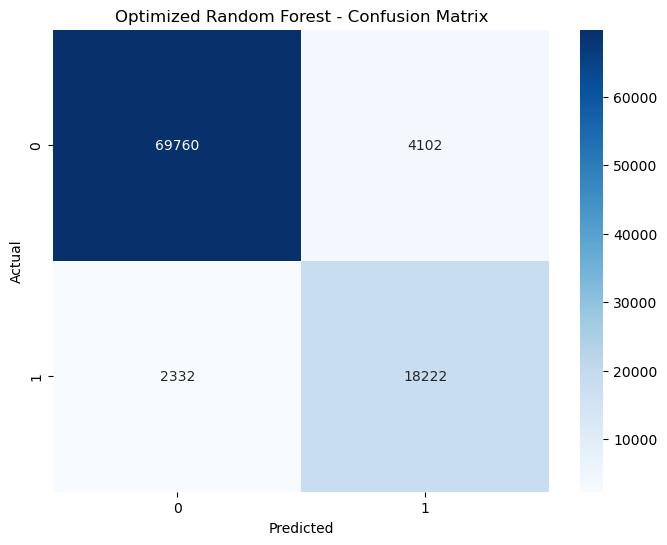

In [36]:
# Confusion Matrix for Optimized Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title('Optimized Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Top 10 Most Important Features:
                        Feature  Importance
22               Wind_Speed_mph    0.401217
25                         Hour    0.133150
20                Temperature_F    0.104612
21                 Humidity_Pct    0.091302
23             Precipitation_in    0.082567
17  Weather_Category_snow_light    0.050092
24                        Month    0.036166
14  Weather_Category_rain_light    0.026028
8       Weather_Category_cloudy    0.019008
7        Weather_Category_clear    0.017122


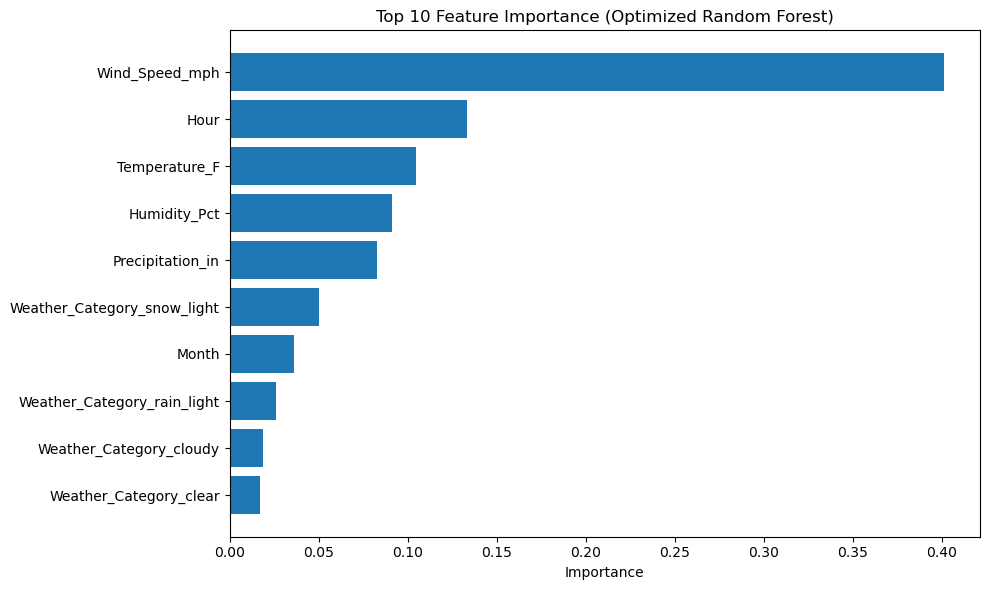

In [ ]:
# Grab the trained RandomForest and the fitted preprocessor from the pipeline
rf = best_model.named_steps["rf"]
pre = best_model.named_steps["preprocess"]

# Get feature names after preprocessing (categoricals expand via one-hot)
cat_feature_names = pre.named_transformers_["cat"].get_feature_names_out(cat_features)
all_feature_names = list(cat_feature_names) + list(num_features)

# Build importance table
feature_importance = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot top 10
top_features = feature_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importance (Optimized Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [42]:
joblib.dump(best_model, "rf_weather_risk_model_2.joblib")

['rf_weather_risk_model_2.joblib']

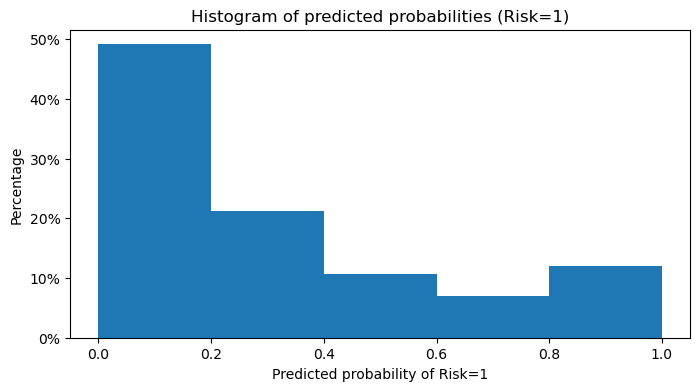

In [45]:
import matplotlib.ticker as mtick

probs = rf_pred_proba[:, 1]
plt.figure(figsize=(8, 4))
plt.hist(probs, bins=5, weights=np.ones_like(probs) / len(probs))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Predicted probability of Risk=1')
plt.ylabel('Percentage')
plt.title('Histogram of predicted probabilities (Risk=1)')
plt.show()

In [44]:
import sklearn
print(sklearn.__version__)


1.5.1
